## Model Uncertainty

In today's blog we'll be exploring the quatification of uncertainty in our model's predictions. Before we dive into the specifics...why do we care about uncertainty? Why not just make our best guess and geton with it? 

Well, imagine you are designing an image recognition model for a self driving car. This model sees an image taken from the front of the car and makes a prediction: obstructed road or unobstructed road. Let's say that we are driving in a car using this model and the model makes the prediction "unobstructed road" but the model very uncertain about this prediction. If you were in that car, would you want the car to stop or to keep driving? Personally, I'd want the car to stop. I don't car that the model predcited that the road is unobstructed, I care more about the fact that the model is very uncertain about it's prediction and my life is on the line!

So how can we get uncertainty estiamtes from our model? There is a wealth of literature on this topic and I don't ahve nearly enough time to cover this topic in any sort of depth or breadth. Instead I'll work through a simple example of one way you might get at uncertainty measurements and then point you in the direction of some neat next steps you could explore.

Before we go further, let's define uncertainty. I'll note that a lot of the material in this post is derived from Radford Neal's thesis from the 90s and Yarin Gal's thesis from the late 2010s. 

## What is uncertainty? 

There are three kinds of uncertianty that we really care about. I call these: Aleatoric, Epistemic, and Ontological uncertainty. 

Aleatoric uncertainty (also called liklihood uncertainty) represents noise in the data generating process itself. There is nothing we can do to reduce aleatoric uncertainty since it is inherent to the data. Imagine you have a rifle and you aim it at a target. You shoot the rifle a large number of time and look at the target. No matter how good you are as a rifleman, the bullets will never hit at exactly the same point due to minute imprefections in the barrel, changes in wind and air pressure, and a number of other factors. The uncertainty in the bullet's location in the target due to these uncontrollable factors is irreducible and we will enver collect enough information to truely understand the causes of this error.

Epistemic uncertainty (also called model uncertainty) is the uncertainty we have that a particular model describes our data. There can be numerous reasons for this uncertainty. Perhaps we have too simple of a model and it fails to account for all of the factors that contibute to the outcome we want to predict. Perhaps we have insufficient data resulting in models that are inadequate for the predictions we want to make. Perhaps multiple models describe our data equally well and we don't know which one to use! Imagine you are asked to predict when a bunch of objects will hit the ground when dropped from a plane. You create a model using the known acceleration due to gravity and height of the plane. Your simple model may work well, but it would ignore the effects of drag/air resistance. We could build in a model of drag and incorporate it into the model, but we might choose not to leading to an increase in epistemic uncertainty.

Ontological uncertainty (a term I borrowed from my colleague Jason Wittenbach) is the uncertainty that the data we want to predict was generated from the same process as the data we trained on. Typically, data scientists will just make the assumption that this is true. They will then make regular checks of the model's accuracy in production to ensure that there isn't performance degredation/model drift that might indicate that the underlying process by which the data is generated has changed/drifted away from the training set. Imagine that you have built a model to classify numeric digits. One day some smart alec feeds your model a letter! Ideally your model would be able to say "hmmm, this doesn't look like anything I've seen before, I guess my prediction for this input should be very uncertain". Unfortunately, we often just assume that when the model starts making bad predictions that we ahve reached an area of high ontological uncertainty...but in a perfect world we could directly measure the ontological uncertainty. 

## Quantifying Uncertainty

So how do we quantify uncertainty? We'll start with epistemic uncertainy. 

Imagine that we are trying to build a linear regression model of housing prices. There might be a great number (potentially infinite!) of model parameters that could describe our data. Some of these parameters lead to more accurate models than others. Many modelers pick the parameters that maximize the liklihood that the train data was generated using a particular model architecture. They then assume that these are the right parameters (maximum liklihood estimation). Instead of doing this, we could find the probability that certain parameters describe the data that we are seeing. We could then say that the output of a particular model (set of parameters) has the same probability of being the correct output as the probability that the parameters that generated that output describe the train data! This is basic bayesian statistics.

To try to make things clearer for those not well aqainted with bayesian statistics: Let's say that we are 50% certain that the data was generated from the model y = .3 * x + 4. Then we are 50% certain that the output of this model is the 'correct' output. 

I won't cover how we arrive at the probability distribution over model parameters. If you are really interested, please check out my bayesian statistics course Bayes by Example.

Capturing aleatroic uncertainty is a bit harder. I'll note here that my example code below does not quantify aleatoric uncertainty. Models that effectively combine measures of aleatroic and epistemic uncertainty are relatively new and rather complicated. I've intentionally training such a model in this blog post to keep things simple, but if you are interested in diving deeper, here is a good reference paper: [What Uncertainties Do We Need in Bayesian Deep
Learning for Computer Vision?](https://arxiv.org/pdf/1703.04977.pdf). The basic premise is to model a liklihood uncertainty estimate as part of the regression.

Finally, we have ontological uncertainty. This is often thought of as the hardest uncertainty to quanitfy, but it doesn't have to be. To quantify ontological uncertainty we will build a generative model over our train set. Assuming we can build an accurate model, then we can say that our ontological uncertainty over a test sample is proportionate to the probability that it fits our generative model over the train set. 

Ok, let's get down to the code and see if we can't implement some of these concepts!

## Image Recognition and Uncertainty

Significant parts of this tutorial are taken from [MNIST for ML Beginners](https://www.alpha-i.co/blog/MNIST-for-ML-beginners-The-Bayesian-Way.html/). I disagree with many of the conclusions made in the artice, but the code is good. The writer of that post (in my opinion) puts too much faith in his model's uncertainty measurements. I'll demonstrate why this is suboptimal in the example below. 

The task below is to correctly classify handwritten digits. For example, a handwritten nine should be classified as a nine. THis is an extremely popular image recognition data set called MNIST.

The bayesian neural net we use below for classification is trained using variational inference. I considered using bayesian approximation by dropout as Yarin Gal recommends, but I really do like lean as clsoe to the fully bayesian methods as possible. I may do a future blog post using the dropout method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

/Users/jamesmontgomery/anaconda/envs/bayes_env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

# We use a placeholder for the labels in anticipation of the traning data.# We us 
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 27775.867


In [4]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compute the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())
    
samples = np.array(samples).T
probs = np.array(prob_lst)

Here we compute the accuracy of the model. For each sample we compute the predicted class and compare with the test labels. Predicted class is defined as the one which has maximum proability. We perform this test for each (w,b) in the posterior giving us a set of accuracies. Finally we make a histogram of accuracies for the test data.

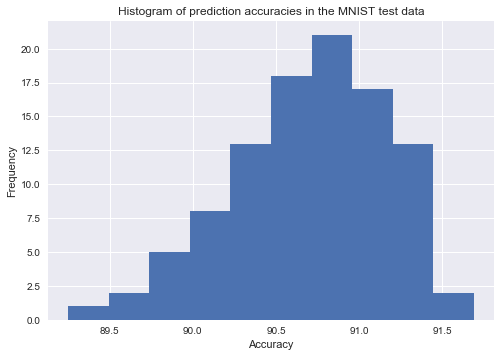

In [5]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

Next we compute the mean of probabilties for each class for all the (w,b) samples. We then use the class with maximum of the mean proabilities as the prediction. In other words, we have used (w,b) samples to construct a set of models and used their combined outputs to make the predcitions. You'll notice that our model is doing pretty well!

In [10]:
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("Test Accuracy = {}%".format( (Y_pred == Y_test).mean()*100 ) )

Test Accuracy = 92.4%


Let's dive into how we can look at the uncertainties of our predictions. We'll begin by looking at a single example. Below I plot the sample. It's simply the number seven. I've taken this sample from the test set. Then we recreate the posterior sampling procedure above for this single sample and plot the distribution of predictions. This distribution captures the epistemic uncertainty of our model prediction. As you can see, we are very certain about our prediction.

('truth = ', 7)


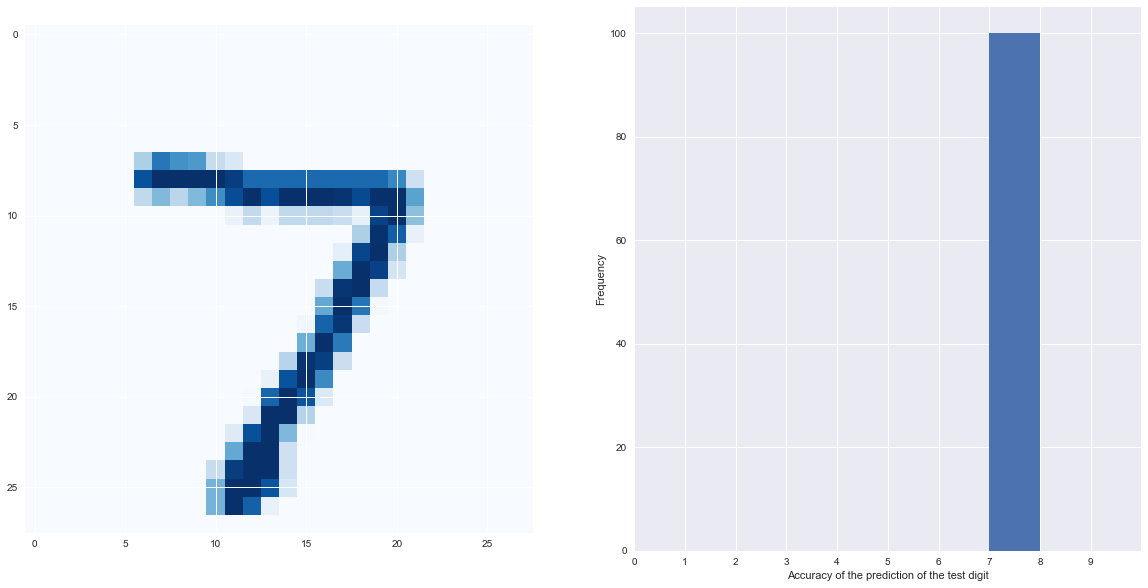

In [66]:
image = 0

test_image = X_test[image]
test_label = Y_test[image]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))

sing_img_probs = probs[:,image,:].argmax(axis=1)

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(pixels,cmap='Blues')

plt.subplot(1, 2, 2)
plt.hist(sing_img_probs,bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")
plt.show()

There are also examples where our model is very uncertain. Below I show an example where some of our model parameters resulted in a prediction of 0 and some resulted in a prediction of 8. Since our models disagree we end up with high model uncertainty. 

('truth = ', 9)


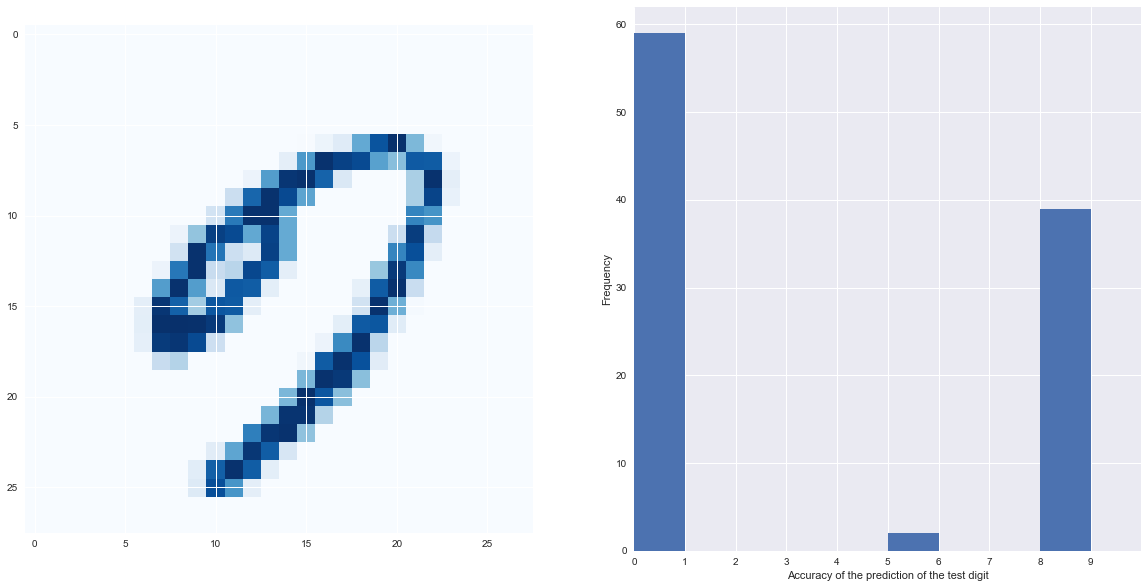

In [73]:
image = 4163

test_image = X_test[image]
test_label = Y_test[image]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))

sing_img_probs = probs[:,image,:].argmax(axis=1)

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(pixels,cmap='Blues')

plt.subplot(1, 2, 2)
plt.hist(sing_img_probs,bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")
plt.show()

Now many blogs claim that the uncertainty measurements above are good enough to capture not only epistemic uncertainty, but also ontological uncertainty. Let's try delving deeper into this concept to see if this is true. We'll read in a dataset of hand writen letters from the english alphabet. These represent classes that our model has never seen and are generated from a different process from the mnist data (letters are NOT numbers).

In [75]:
not_mnist = input_data.read_data_sets("./notMNIST_data/", one_hot=True)
# Load the test images from the data and their lables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

Extracting ./notMNIST_data/train-images-idx3-ubyte.gz
Extracting ./notMNIST_data/train-labels-idx1-ubyte.gz
Extracting ./notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./notMNIST_data/t10k-labels-idx1-ubyte.gz


('truth = ', 5)


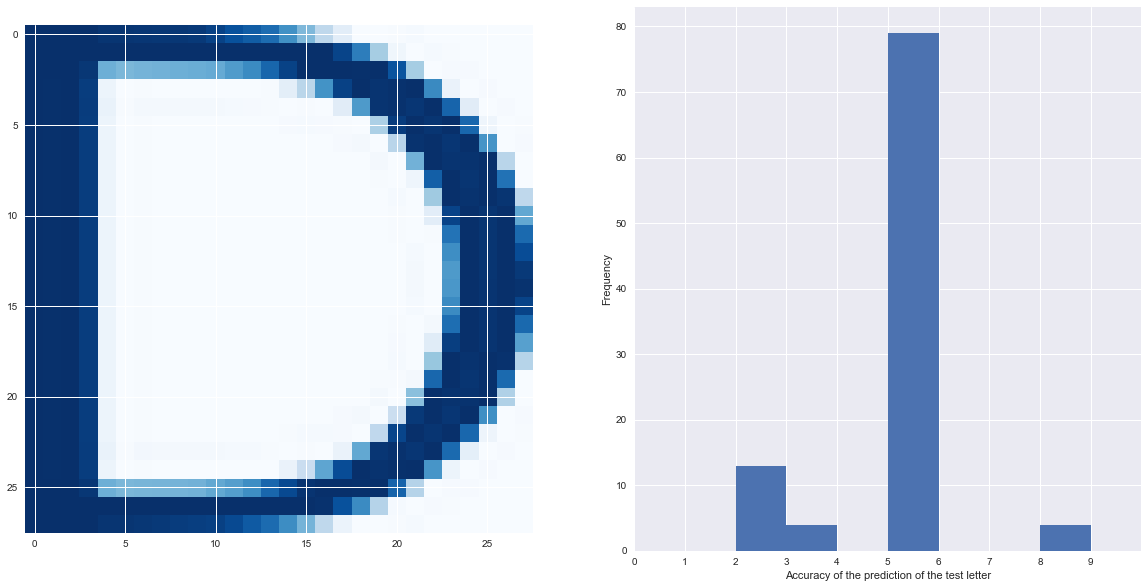

In [77]:
test_image = Xnm_test[1]
test_label = Ynm_test[1]
pixels = test_image.reshape((28, 28))

nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[1:2],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())
    
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(pixels,cmap='Blues')

plt.subplot(1, 2, 2)
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")
plt.show()

In the example above our model sees the letter 'D' and predicts that it is the digit '5'. However, it seems to be somewhat uncertain about it's prediction. Is our model capturing ontological uncertainty? 

Let's look at a different not-mnist case. Look at the predictions for the letter below. 

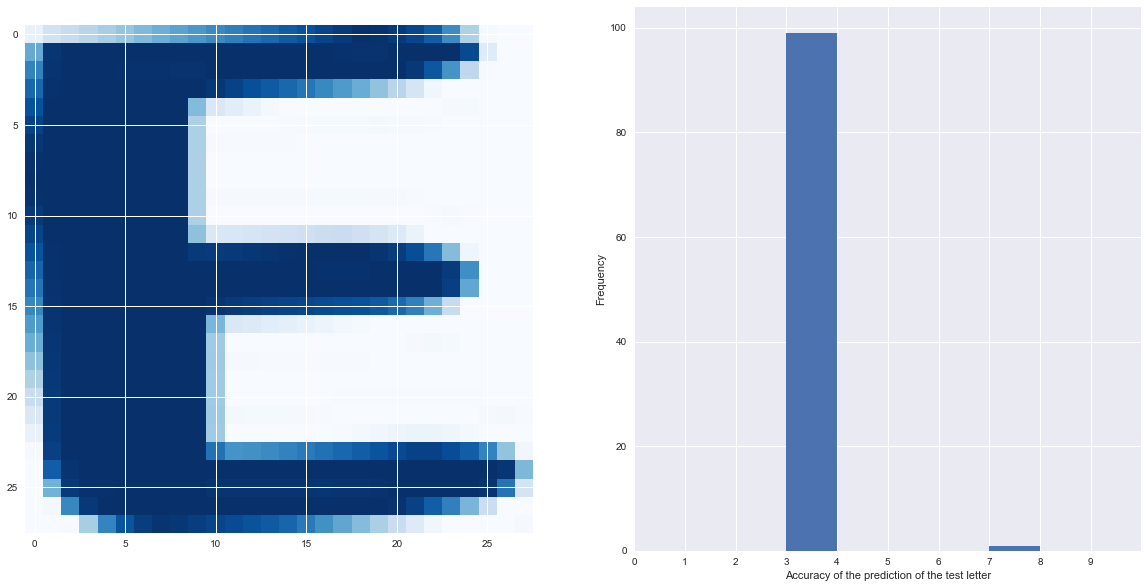

In [78]:
test_image = Xnm_test[0]
test_label = Ynm_test[0]
pixels = test_image.reshape((28, 28))

nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())
    
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(pixels,cmap='Blues')

plt.subplot(1, 2, 2)
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")
plt.show()

Wow! Our model is 100% certain that the letter 'E' is the number '3'. In this case it seems like our model completely fails to capture the ontological uncertainty. Let's see if we can come up with a methodology to capture ontological uncertainty.

To capture ontological uncertainty we're going to build a generative model around our train data. This model will try to build a statistical model of our data such that we can say if new data is like or unlike the train data. 

I've explored a number of generative models in my previous posts. Today we'll use a much more flexible model than usual. We'll be using an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder). I've based my code on this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html). Our autoencoder is a neural network that tries to predict it's own inputs. We add on regularization terms to the network so that the model needs to learn a powerful low dimensional representation of the data so that it can try to predict it's own inputs. You can think of this as akind of compression. The inputs are very high dimensional, the middle layers are low dimensional, and the output is high dimensional. For the outputs to be accurate the model needs to learn informative low dimensional representations of our data. 

This low dimensional representation will be specific to the train set. Therefore our model will be able to accurately recreate samples from the train set, but will be bad at recreating samples from other kinds of data. We can use this fact to model the error distribution over the train set and use that as a generative model of the train set. If we run a new sample through the autoencoder and the error is on the tails of our distribution of train errors, then we might say that it is unlikely that the new sample was generated from the same process as the train data.

This is a very simplified version of how autoencoders should be used as generative models, but I'm cutting corners to save time. I think this example should be illustrative of the high level concepts I'm trying to convey. 

First we build and train our autoencoder on the mnist data.

In [79]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [80]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [81]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 90s 1ms/step - loss: 0.2168 - val_loss: 0.1606
Epoch 2/50
60000/60000 [==============================] - 59s 990us/step - loss: 0.1512 - val_loss: 0.1392
Epoch 3/50
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1366 - val_loss: 0.1319
Epoch 4/50
60000/60000 [==============================] - 56s 932us/step - loss: 0.1293 - val_loss: 0.1252
Epoch 5/50
60000/60000 [==============================] - 55s 917us/step - loss: 0.1251 - val_loss: 0.1240
Epoch 6/50
60000/60000 [==============================] - 58s 964us/step - loss: 0.1221 - val_loss: 0.1188
Epoch 7/50
60000/60000 [==============================] - 58s 963us/step - loss: 0.1197 - val_loss: 0.1208
Epoch 8/50
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1178 - val_loss: 0.1204
Epoch 9/50
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1163 - val_loss: 0.

Can our autoencoder accurately reconstruct our data? Below I plot original images sampled from mnist and the autoencoder reconstructions. As you can see, we do pretty well!

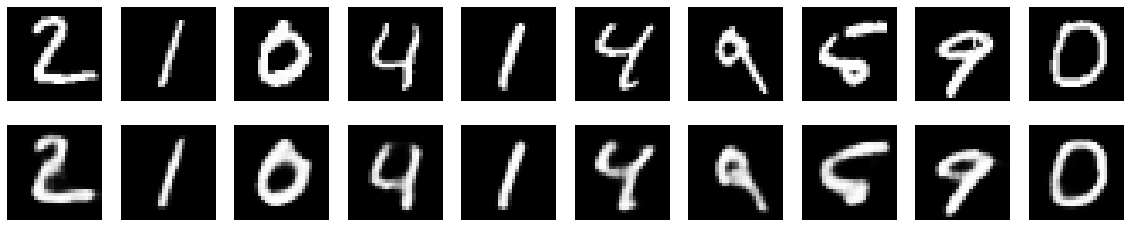

In [82]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    i = i+1
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Can our model recreate the letters dataset well? Let's try to recreate the letter 'E'. As you can see, the autoencoder sucks at recreating letters since it's only seen the mnist digits.

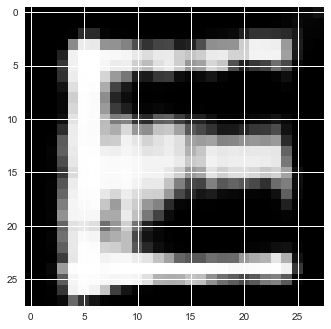

In [83]:
test_image = Xnm_test[0]
pixels = test_image.reshape((1,28, 28,1))
decoded_imgs = autoencoder.predict(pixels)

plt.imshow(decoded_imgs[0].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

Visualising the autoencoder outputs is fun, but we formulate the autoencoders learning in terms of numbers. Let's compare the mean absolute error of our autoencoder for the letter 'E' and the number '3'. You'll notice a huge difference! 

In [89]:
a = Xnm_test[0].reshape((1,28, 28,1))
b = autoencoder.predict(a)
E_error = np.mean(np.abs(a-b))

a = X_test[18:19].reshape((1,28, 28,1))
b = autoencoder.predict(a)
Three_error = np.mean(np.abs(a-b))

print "Error for 3: {} \nError for E: {}".format(Three_error, E_error)

Error for 3: 0.0642236322165 
Error for E: 0.333499759436


Using the same methods as I did in my post of generative models and DGAs, I could use the reconstruction errors over mnist to create a generative model over the mnist set. The probability that a new sample fits that generative model could be used to quantify the ontological uncertainty that the bayesian neural net failed to capture!

## Parting Words

Ok, so why is this all so cool? We just built a model (really two models) that not only give us accurate predictions, but give us measures of our uncertainly. If we run across a sample that would be classified differently by equally valid models we will know because our epistemic uncertainty will be high. If we run across a sample that did not come from our train data we will know because our ontological uncertainty will be high. In either of these cases we will know to not trust our model's predictions too much. 